In [1]:
# change code cells width
from IPython.display import display, HTML
display(
HTML(data = """
<style>
  div#notebook-container {width: 75%;}
  div#menubar-container {width: 65%;}
  div#maintoolbar-container {width: 55%;}
</style>

"""))


# display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'



# pandas DataFrame displayed output size
import pandas as pd
pd.options.display.max_rows = 500
pd.options.display.max_columns = 40

# turning off scientific format for number in pandas DataFrames
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# size of plot made by plotnine
import plotnine
plotnine.options.figure_size = (20, 10) # width, hight



import os

# import modules.data_analysis_tools
# import modules.grid_search

%run "modules/data_analysis_tools.py"
%run "modules/F_regression.py"
%run "modules/grid_search.py"



# list of available models
models_base = {  'rf' :RandomForestRegressor(n_estimators=10, max_depth=6)
                ,'gb' :GradientBoostingRegressor(n_estimators=10, max_depth = 6)
                ,'cat':CatBoostRegressor(iterations=10,  random_seed=123)
                ,'ab' :AdaBoostRegressor(n_estimators = 30)
                ,'knn':skl.neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=10, p=2, metric='minkowski')
                #,'nb' :skl.naive_bayes.GaussianNB(priors=None, var_smoothing=1e-09)
                ,'lgbm':LGBMRegressor(n_estimators = 50, n_jobs = 5, learning_rate = 0.1, max_depth = 7)
                #,'lr':LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None, positive=False)
#                 ,'xgb':XGBRegressor(n_estimators = 50, leanring_rate = 0.1, max_depth = 7, n_jobs = 5)
                }

# main target variable
var_y = 'price'

# date varaibles (useful for quick filtering date variables)
var_date = ['date']

path_results = 'F:\\1_Programs_and_programing\\DS_proj\\classification_python\\results\\'





dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')
# %Y: Year (4 digits)
# %m: Month
# %d: Day of month
# %H: Hour (24 hour)
# %M: Minutes
# %S: Seconds
# %f: Microseconds

data = pd.read_csv( 'data/diamonds.txt'
                   , sep = ','
                   , decimal = '.'
                   , parse_dates = ['date']
                   , na_values = ''
                   , date_parser = dateparse
                   , encoding = 'windows-1252' # useful encodings: latin1, latin2, utf8, windows-1252
                   , converters = {'z':float})   

# data = data.drop(data.columns[0], axis = 1) # for dropping first column with index if necessary


data['year'] = pd.DatetimeIndex(data['date']).year 
data['month'] = pd.DatetimeIndex(data['date']).month
data['quarter'] = data['date'].dt.quarter
data.loc[data['quarter']<3,'half'] = int(0)
data.loc[data['quarter']>=3,'half'] = int(1)
data['half'] = data['half'].astype(int)
data.loc[data['month'] <  10,'year_month'] = data['year'].astype(str) + '_0' + data['month'].astype(str)
data.loc[data['month'] >= 10,'year_month'] = data['year'].astype(str) + '_' + data['month'].astype(str)
data['year_quarter'] = data['year'].astype(str) + '_' + data['quarter'].astype(str) 
data['year_half'] = data['year'].astype(str) + '_' + data['half'].astype(str) 

h('data size')
data.shape

h('columns type')
data.dtypes

h('variables statistics')
glimpse_data(data, var_cat = list(data.dtypes[data.dtypes=='object'].index) )


,target_multi_label_missing,target_multi_label,z_missing,y_missing,y,target_missing,carat,date,month,price_missing,z,target,carat_missing,x,half,table_missing,quarter,year,table,depth,x_missing,depth_missing,price,cut,color,clarity,cut_missing,color_missing,clarity_missing,year_month,year_quarter,year_half
NA,5394.000,0.000,5394.000,5394.000,0.000,5394.000,0.000,0,0.000,5394.000,0.000,0.000,5394.000,0.000,0.000,5394.000,0.000,0.000,0.000,0.000,5394.000,5394.000,0.000,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.0
NA_proc,0.100,0.000,0.100,0.100,0.000,0.100,0.000,0.0,0.000,0.100,0.000,0.000,0.100,0.000,0.000,0.100,0.000,0.000,0.000,0.000,0.100,0.100,0.000,0,0,0,5394,5394,5394,0,0,0
min,0.000,0.000,0.000,0.000,0.000,NaN,0.200,2019-11-01 00:00:00,1.000,326.000,0.000,0.000,0.200,0.000,0.000,43.000,1.000,2019.000,43.000,43.000,0.000,43.000,326.000,Ideal (21551),G (11292),SI1 (13065),Ideal (19337),G (10144),SI1 (11739),2020_01 (18135),2019_4 (35207),2019_1 (35207)
q_25,0.000,0.000,2.910,4.720,4.720,0.000,0.400,2019-11-24T00:00:00.000000000,1.000,949.000,2.910,0.000,0.400,4.710,0.000,56.000,1.000,2019.000,56.000,61.000,4.710,61.000,950.000,Premium (13791),E (9797),VS2 (12258),Premium (12413),E (8797),VS2 (11064),2019_12 (17779),2020_1 (18733),2020_0 (18733)
q_50,1.000,1.000,3.520,5.710,5.710,0.000,0.700,2019-12-17T00:00:00.000000000,11.000,2404.000,3.530,0.000,0.700,5.700,1.000,57.000,4.000,2019.000,57.000,61.800,5.700,61.800,2401.000,Very Good (12082),F (9542),SI2 (9194),Very Good (10914),F (8639),SI2 (8281),2019_11 (17428),NaN,NaN
q_75,3.000,3.000,4.030,6.530,6.540,1.000,1.040,2020-01-09T00:00:00.000000000,12.000,5329.000,4.040,1.000,1.040,6.540,1.000,59.000,4.000,2020.000,59.000,62.500,6.540,62.500,5324.250,Good (4906),H (8304),VS1 (8171),Good (4438),H (7458),VS1 (7359),2020_02 (598),NaN,NaN
max,4.000,4.000,31.800,58.900,58.900,NaN,5.010,2020-02-01 00:00:00,12.000,18823.000,31.800,1.000,5.010,10.740,1.000,95.000,4.000,2020.000,95.000,79.000,10.740,79.000,18823.000,Fair (1610),D (6775),VVS2 (5066),Fair (1444),D (6065),VVS2 (4561),NaN,NaN,NaN


In [73]:



def var_numerical_vs_numerical_summary(data, var_x, var_y, var_y_num, var_group=None, round=2, filters_num=None):
    display(h('statistics'))
    print('braki danych: ' + str(np.round(100 * sum(pd.isna(data[var_x])) /len(data) ,2) ) + ' %' )
    display(statistics_numeric(  data      = data  # data set
                       , var_x     = var_x # variable
                       , var_group = None  # grouping variable (optional)
                       , x_lim     = None  # min-max values limit (for example to remove outliers)
                       , round     = 2))    # number of decimal places to round

    display(h('statistics - grouped'))
    display(statistics_numeric(  data      = data  # data set
                       , var_x     = var_x # variables
                       , var_group = var_group  # grouping variable (optional)
                       , x_lim     = None  # min-max values limit (for example to remove outliers)
                       , round     = round))    # number of decimal places to round

    if filters_num is not None:
        data = outliers_num_fitler(data=data, var=var_x, filters_num=filters_num)

    display(h('density plot'))
    # bez grupowania
    display(plot_density(  data      = data  # data set
                 , var_x     = var_x # grouping variable (optional)
                 , var_group = None  # variable
                 , bw_method = 0.2   # bandwidth for kernel
                 , x_lim     = None  # min-max values limit (for example to remove outliers)
                 , fig_w     = 12    # plot width
                 , fig_h     = 8))    # plot hight

    display(h('density plot - grouped'))
    display(plot_density(  data      = data  # data set
                 , var_x     = var_x # grouping variable (optional)
                 , var_group = var_group # variables
                 , bw_method = 0.2   # bandwidth for kernel
                 , x_lim     = None  # min-max values limit (for example to remove outliers)
                 , fig_w     = 12    # plot width
                 , fig_h     = 8))    # plot hight
    
    if var_group is None:
        facet = None
    else:
        facet = '.~'+var_group
    
    display(plot_scatterplot( data = data
                                , x_var    = var_x
                                , y_var    = var_y
                                , filter   = None
                                , fill_var = None
                                , facet    = facet
                                , x_lim    = [np.nan, np.nan]
                                , alpha    = 0.5
                                , size     = 2
                                , frac     = 1
                                , title    = 'scatter plot - '.format()
                                , fig_w    = 15
                                , fig_h    = 7))
    
    
    display(h('pearson correlation with target'))
    if var_group is None:
        display(correlation_pearson(data=data, vars = [var_x, var_y]).iloc[0,1])
    else:
        correlations_dict = dict()
        for i in list(data[var_group].drop_duplicates()):
            correlations_dict[i]=correlation_pearson(data=data[data[var_group]==i], vars = [var_x, var_y]).iloc[0,1]
        print(correlations_dict)
    display(h('mutual information normalized'))
    if var_group is None:
        display(ennemi.estimate_mi(y=data[var_x], x=data[var_y], normalize=True))
    else:
        mi_dict = dict()
        for i in list(data[var_group].drop_duplicates()):
            mi_dict[i]=np.round(ennemi.estimate_mi(y=data.loc[data[var_group]==i, var_x], x=data.loc[data[var_group]==i, var_y], normalize=True ).iloc[0,0], round)
        print(mi_dict)



braki danych: 0.0 %


,min,q_05,q_10,q_25,q_50,q_75,q_90,q_95,max
0,326,544.000,646.000,950.000,2401.000,5324.250,9821.000,13107.100,18823


,min_,q_10,q_25,q_50,q_75,q_90,max_
cut,,,,,,,
Fair,337,1114,2050.250,3282.000,5205.500,9133.700,18574
Good,327,603,1145.000,3050.500,5028.000,8736.000,18788
Ideal,326,652,878.000,1810.000,4678.500,9077.000,18806
Premium,326,709,1046.000,3185.000,6296.000,11413.000,18823
Very Good,336,576,912.000,2648.000,5372.750,9680.900,18818


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

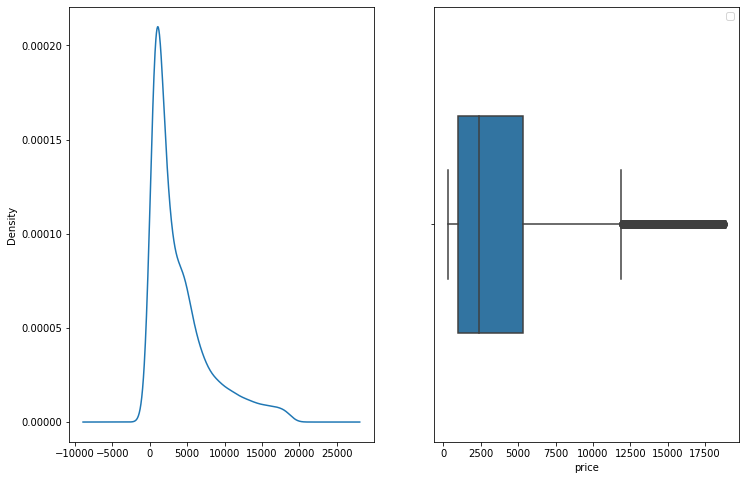

None

<Figure size 432x288 with 0 Axes>

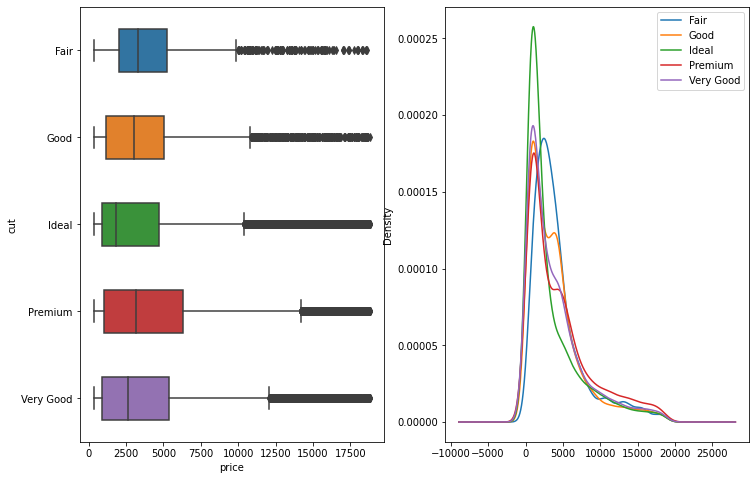

None

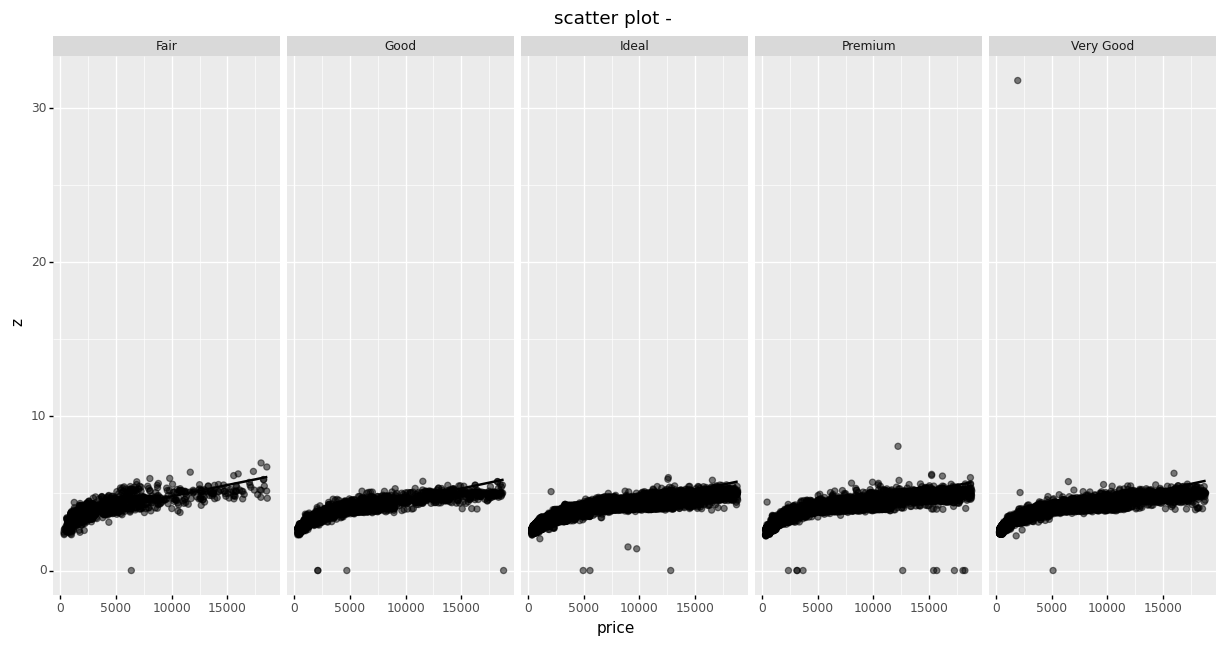

<ggplot: (134127522413)>

{'Ideal': 0.89, 'Premium': 0.87, 'Good': 0.86, 'Very Good': 0.82, 'Fair': 0.8}


{'Ideal': 0.97, 'Premium': 0.97, 'Good': 0.96, 'Very Good': 0.97, 'Fair': 0.9}


In [74]:
var_numerical_vs_numerical_summary(data=data, var_x='price', var_y='z', var_y_num='cut', var_group='cut', round=2, filters_num=None)



In [ ]:
def var_categorical_numerical_summary(data, var_x, var_y, x_angle = 0, normalize='index', x_text_size = 7):
    display(h('statistics by target classes'))
    print('braki danych: ' + str(np.round(100 * sum(pd.isna(data[var_x])) / len(data), 2 )  ) + ' %' )
    display(cross_tab(  data      = data
              , var_1     = var_y
              , var_2     = var_x
              , round     = 1
              , normalize = normalize))

    plot_percent_data(data, var_y, var_x, x_angle=x_angle, x_text_size = x_text_size)
    plot_count_bar(data, var_y, var_x, x_angle = x_angle, x_text_size = x_text_size)

    display(h('V-cramer and WoE'))
    display(correlation_cramers_v(  var_1 = data[var_x]
                          , var_2 = data[var_y]
                          , round = 2))

    display(correlation_woe(  data
                    , var_x = var_x
                    , var_y = var_y))